#Natural Language Processing for COVID-19 vaccine misinformation study




In [ ]:
#library importations

import os
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from scipy.stats import f
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
nltk.download('punkt')
import numpy as np  
import random  
import string
import bs4 as bs  
import urllib.request  
import re  
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
nltk.download('wordnet')
import heapq
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.test.utils import common_texts
from string import punctuation
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
import gensim
import gensim.downloader as gensim_api

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#First we read the database 
data = pd.read_csv('covidvaccine.csv', index_col=0)   

data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,7,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
user_name,,,,,,,,,,,,
MyNewsNE,Assam,MyNewsNE a dedicated multi-lingual media house...,24-05-2020 10:18,64.0,11,110,FALSE,18-08-2020 12:55,Australia to Manufacture Covid-19 Vaccine and ...,['CovidVaccine'],Twitter Web App,False
Shubham Gupta,NaN,I will tell about all experiences of my life f...,14-08-2020 16:42,1.0,17,0,FALSE,18-08-2020 12:55,#CoronavirusVaccine #CoronaVaccine #CovidVacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,False
Journal of Infectiology,NaN,Journal of Infectiology (ISSN 2689-9981) is ac...,14-12-2017 07:07,143.0,566,8,FALSE,18-08-2020 12:46,Deaths due to COVID-19 in Affected Countries\n...,NaN,Twitter Web App,False
Zane,NaN,Fresher than you.,18-09-2019 11:01,29.0,25,620,FALSE,18-08-2020 12:45,@Team_Subhashree @subhashreesotwe @iamrajchoco...,NaN,Twitter for Android,False
Ann-Maree O’Connor,"Adelaide, South Australia",Retired university administrator. Melburnian b...,24-01-2013 14:53,83.0,497,10737,FALSE,18-08-2020 12:45,@michellegrattan @ConversationEDU This is what...,NaN,Twitter Web App,False
...,...,...,...,...,...,...,...,...,...,...,...,...
NOLA Ready,"New Orleans, LA",NOLA Ready is the City of New Orleans emergenc...,8/31/2009 23:36,44539.0,1024,9200,True,2/19/2021 0:01,"Starting Monday, @LouisianaGov announced that ...",['COVIDVaccine'],Twitter Web App,False
اعدموا الخونة,In Between,I am the person to whom it always occurs the a...,5/28/2009 1:18,271.0,74,379,False,2/19/2021 0:00,Does anyone know what’s meant when they talk a...,['COVIDVaccine'],Twitter for iPhone,False
Dolores Huerta Foundation,"Central Valley, CA",Organizes at the grassroots level by engaging ...,3/27/2014 20:36,4093.0,271,644,False,2/19/2021 0:00,#FRESNOCOUNTY: Find out if you're eligible for...,['FRESNOCOUNTY'],Hootsuite Inc.,False


##Database processing

In [ ]:
#Check if there is missing data, particularly on the "text" column.
data.isnull().sum()

user_location       30719
user_description     8610
user_created            4
user_followers          5
user_friends            5
user_favourites         5
user_verified           5
date                    6
text                    5
hashtags            48183
source                133
is_retweet             10
dtype: int64

In [ ]:
#missing data is dropped
data = data[data['text'].notna()]

## Conspiracies

These words were isolated and used in order to mark whether the text of each tweet contained any misinformation. 

In [ ]:
conspiracy_words = ['hoax','fake','elites','sheep','plandemic','plandem','autism','mind control', 'mercury','chemicals','toxins','toxic','reset','depopulation','nano','scaremonger','fearmonger','comply','beast'

                    'alumin','antifreeze', 'depopu','globali','wake']
conspiracy_words


['hoax',
 'fake',
 'elites',
 'sheep',
 'plandemic',
 'plandem',
 'autism',
 'mind control',
 'mercury',
 'chemicals',
 'toxins',
 'toxic',
 'reset',
 'depopulation',
 'nano',
 'scaremonger',
 'fearmonger',
 'comply',
 'beastalumin',
 'antifreeze',
 'depopu',
 'globali',
 'wake']

In [ ]:
#We used "あ" in order to mark user descriptions that did not contain any characters. 
#We cleaned and checked the data. 

data['user_description'] = data['user_description'].fillna('あ')
data.isnull().sum()
data['user_location'] = data['user_location'].fillna('Not Available')
data.isnull().sum()
data['hashtags'] = data['hashtags'].fillna('None')
data.isnull().sum()
data['source'] = data['source'].fillna('None')
data.isnull().sum()
data = data[data['is_retweet'].notna()]
data.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

user_location       0
user_description    0
user_created        0
user_followers      0
user_friends        0
user_favourites     0
user_verified       0
date                0
text                0
hashtags            0
source              0
is_retweet          0
dtype: int64

In [ ]:
#In order to obtain useful information, the ntlk (Natural Language Toolkit) library will be used. 
#The most important feature in this case is the "text" column, therefore we will apply natural language processing in order to create new features in the database. 
#First we will rid of uppercase and we will delete the extra spaces and punctuation, as well as applying Lemmatization and stemming to the words


lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 

def lower_text(text):
    return text.lower()

def is_conspiracy(text):
    if any(map(text.__contains__, conspiracy_words)):
      return 1
    else:
      return 0

def symbols(text):
    return re.sub(r'\W',' ',text)
def spaces(text):
    return re.sub(r'\s+',' ',text)
def lemmatize(tokens):
    new_tokens = []
    for token in tokens:
      new_tokens.append(lemmatizer.lemmatize(token))
    return new_tokens
def stem(tokens):
    new_tokens = []
    for token in tokens:
      new_tokens.append(ps.stem(token))
    return new_tokens




data['text'] = data['text'].apply(lower_text)
print('done')
data['text'] = data['text'].apply(symbols)
print('done')
data['is_conspiracy'] = data['text'].apply(is_conspiracy)
print('done')

data['user_description'] = data['user_description'].apply(lower_text)
print('done')
data['user_description'] = data['user_description'].apply(symbols)
print('done')

data['user_description'] = data['user_description'].apply(spaces)
print('done')

#We tokenize the words in the text column, creating a separate column. Addionally, we record apply Lemmatization and stemming
data['text_tokens'] = data.apply(lambda row: nltk.word_tokenize(row["user_description"]), axis=1)
print('done')
data['text_tokens'] = data['text_tokens'].apply(lemmatize)
print('done')
data['text_tokens'] = data['text_tokens'].apply(stem)
print('done')

done
done
done
done
done
done
done
done
done


In [ ]:
datatest = data.copy()
def separate_date(text):
  if "-" in text:
    return text.split("-")
  elif "/" in text:
    return text.split("/")

def get_day(lis):
  x = lis[0]
  return x

def get_month(lis):
  x = lis[1]
  return x

def get_year(lis):
  x = lis[2]
  x = x.split(" ")
  return x[0]

datatest['user_created'] = datatest['user_created'].apply(separate_date)
datatest['created_d'] = datatest['user_created'].apply(get_day)
datatest['created_m'] = datatest['user_created'].apply(get_month)
datatest['created_y'] = datatest['user_created'].apply(get_year)

datatest['date'] = datatest['date'].apply(separate_date)
datatest['date_d'] = datatest['date'].apply(get_day)
datatest['date_m'] = datatest['date'].apply(get_month)
datatest['date_y'] = datatest['date'].apply(get_year)
datatest

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,is_conspiracy,text_tokens,created_d,created_m,created_y,date_d,date_m,date_y
user_name,,,,,,,,,,,,,,,,,,,,
MyNewsNE,Assam,mynewsne a dedicated multi lingual media house...,"[24, 05, 2020 10:18]",64.0,11,110,FALSE,"[18, 08, 2020 12:55]",australia to manufacture covid 19 vaccine and ...,['CovidVaccine'],Twitter Web App,False,0,"[mynewsn, a, dedic, multi, lingual, medium, ho...",24,05,2020,18,08,2020
Shubham Gupta,Not Available,i will tell about all experiences of my life f...,"[14, 08, 2020 16:42]",1.0,17,0,FALSE,"[18, 08, 2020 12:55]",coronavirusvaccine coronavaccine covidvacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,False,0,"[i, will, tell, about, all, experi, of, my, li...",14,08,2020,18,08,2020
Journal of Infectiology,Not Available,journal of infectiology issn 2689 9981 is acce...,"[14, 12, 2017 07:07]",143.0,566,8,FALSE,"[18, 08, 2020 12:46]",deaths due to covid 19 in affected countries r...,None,Twitter Web App,False,0,"[journal, of, infectiolog, issn, 2689, 9981, i...",14,12,2017,18,08,2020
Zane,Not Available,fresher than you,"[18, 09, 2019 11:01]",29.0,25,620,FALSE,"[18, 08, 2020 12:45]",team_subhashree subhashreesotwe iamrajchoco...,None,Twitter for Android,False,0,"[fresher, than, you]",18,09,2019,18,08,2020
Ann-Maree O’Connor,"Adelaide, South Australia",retired university administrator melburnian by...,"[24, 01, 2013 14:53]",83.0,497,10737,FALSE,"[18, 08, 2020 12:45]",michellegrattan conversationedu this is what...,None,Twitter Web App,False,0,"[retir, univers, administr, melburnian, by, bi...",24,01,2013,18,08,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NOLA Ready,"New Orleans, LA",nola ready is the city of new orleans emergenc...,"[8, 31, 2009 23:36]",44539.0,1024,9200,True,"[2, 19, 2021 0:01]",starting monday louisianagov announced that ...,['COVIDVaccine'],Twitter Web App,False,0,"[nola, readi, is, the, citi, of, new, orlean, ...",8,31,2009,2,19,2021
اعدموا الخونة,In Between,i am the person to whom it always occurs the a...,"[5, 28, 2009 1:18]",271.0,74,379,False,"[2, 19, 2021 0:00]",does anyone know what s meant when they talk a...,['COVIDVaccine'],Twitter for iPhone,False,0,"[i, am, the, person, to, whom, it, alway, occu...",5,28,2009,2,19,2021
Dolores Huerta Foundation,"Central Valley, CA",organizes at the grassroots level by engaging ...,"[3, 27, 2014 20:36]",4093.0,271,644,False,"[2, 19, 2021 0:00]",fresnocounty find out if you re eligible for...,['FRESNOCOUNTY'],Hootsuite Inc.,False,0,"[organ, at, the, grassroot, level, by, engag, ...",3,27,2014,2,19,2021


In [ ]:
data = datatest
data[data.is_conspiracy == 1]

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,is_conspiracy,text_tokens,created_d,created_m,created_y,date_d,date_m,date_y
user_name,,,,,,,,,,,,,,,,,,,,
Sandra,Not Available,lithuanian girl mom peace advocate happy happy...,"[18, 09, 2016 15:24]",66.0,317,2419,FALSE,"[18, 08, 2020 02:32]",usa doctors wake up covidvaccine https t co...,['CovidVaccine'],Twitter for iPhone,False,1,"[lithuanian, girl, mom, peac, advoc, happi, ha...",18,09,2016,18,08,2020
⭐️🇺🇸🌹RockysMom67🌹🇺🇸⭐️,"Texas, USA",trumptastic motorcyclemama 2a chl ltc tcb 3rdd...,"[23, 12, 2015 16:43]",6055.0,6388,30288,FALSE,"[17, 08, 2020 12:44]",l k amp learn wakeupamerica walkawayfro...,"['WakeUpAmerica', 'WalkAwayFromDemocrats', 'CO...",Twitter for iPhone,False,1,"[trumptast, motorcyclemama, 2a, chl, ltc, tcb,...",23,12,2015,17,08,2020
🦂cheekyozieclique⚔️,In burning 🔥hell.,the world is beautiful keep the faith never l...,"[6, 3, 2009 23:12]",1083.0,528,5833,FALSE,"[16, 08, 2020 02:45]",coronavirus is a plandemic so billgates can...,"['coronavirus', 'plandemic', 'billgates', 'dep...",Twitter for iPad,False,1,"[the, world, is, beauti, keep, the, faith, nev...",6,3,2009,16,08,2020
"Reverse Engineering Anything; behaviors too,try me",Moderation 4Losers ProcessData,engineer real estate investor research of neur...,"[7, 3, 2012 21:46]",251.0,432,2946,FALSE,"[15, 08, 2020 14:42]",delaware_dhss not one delaware kid has died f...,None,Twitter Web App,False,1,"[engin, real, estat, investor, research, of, n...",7,3,2012,15,08,2020
Red Collie,"Sydney, New South Wales",the real dr horace r drew also known as red co...,"[6, 12, 2018 3:38]",7053.0,5275,8604,FALSE,"[15, 08, 2020 05:50]",covid19vic covidvaccine we have a right to k...,"['COVID19Vic', 'CovidVaccine']",Twitter Web App,False,1,"[the, real, dr, horac, r, drew, also, known, a...",6,12,2018,15,08,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HerHealthMD,Not Available,herhealthmd focuses on the intersection of hea...,"[1, 10, 2021 14:52]",19.0,10,16,False,"[2, 19, 2021 3:31]",another win towards advancing covidvaccine aw...,['Covidvaccine'],Twitter for iPhone,False,1,"[herhealthmd, focu, on, the, intersect, of, he...",1,10,2021,2,19,2021
Heather,New Jersey,あ,"[2, 2, 2011 19:32]",47.0,177,906,False,"[2, 19, 2021 1:55]",show me the conspiracy agenda2030 wakeup ...,"['agenda2030', 'wakeup', 'covid19', 'COVIDVacc...",Twitter for iPhone,False,1,[あ],2,2,2011,2,19,2021
LW,CT,grandmother,"[10, 18, 2015 21:49]",250.0,487,9333,False,"[2, 19, 2021 1:51]",federicacocco i have been tweeting about this...,"['ct', 'ms', 'farmington', 'FVHD']",Twitter for iPad,False,1,[grandmoth],10,18,2015,2,19,2021


In [ ]:
#Generating dictionary
wordfreq = {}
for text in data['text_tokens']:
    for token in text:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1
len(wordfreq)

94140

In [ ]:
#getting rid of uncommon words, single character words and stopwords
stop_words = stopwords.words('english')
words_to_delete = []
for word in wordfreq.keys():
  if wordfreq[word] < 5 or len(word)==1 or (word in stop_words):
    words_to_delete.append(word)
    #wordfreq.pop(word)
print('number of words to delete: '+str(len(words_to_delete)))
for x in words_to_delete:
  wordfreq.pop(x)
len(wordfreq)

number of words to delete: 74110


20030

In [ ]:
#We eliminate the stopwords from the tokenized column. Stopwords are commonly used words that are usually ignored by search engines. 
def filter(tokens):
    lst = []
    for w in tokens:  
      if w not in stop_words:  
          lst.append(w)
    return lst
data['filtered_tokens'] = data['text_tokens'].apply(filter)

In [ ]:
#We will obtain the word count for both filtered and original texts. 
data['word_count_og'] = data.apply(lambda row: len(row["text_tokens"]), axis=1)
data['word_count_ft'] = data.apply(lambda row: len(row["filtered_tokens"]), axis=1)
data

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,is_conspiracy,text_tokens,created_d,created_m,created_y,date_d,date_m,date_y,filtered_tokens,word_count_og,word_count_ft
user_name,,,,,,,,,,,,,,,,,,,,,,,
MyNewsNE,Assam,mynewsne a dedicated multi lingual media house...,"[24, 05, 2020 10:18]",64.0,11,110,FALSE,"[18, 08, 2020 12:55]",australia to manufacture covid 19 vaccine and ...,['CovidVaccine'],Twitter Web App,False,0,"[mynewsn, a, dedic, multi, lingual, medium, ho...",24,05,2020,18,08,2020,"[mynewsn, dedic, multi, lingual, medium, hous,...",11,9
Shubham Gupta,Not Available,i will tell about all experiences of my life f...,"[14, 08, 2020 16:42]",1.0,17,0,FALSE,"[18, 08, 2020 12:55]",coronavirusvaccine coronavaccine covidvacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,False,0,"[i, will, tell, about, all, experi, of, my, li...",14,08,2020,18,08,2020,"[tell, experi, life, video, hope, like, video]",19,7
Journal of Infectiology,Not Available,journal of infectiology issn 2689 9981 is acce...,"[14, 12, 2017 07:07]",143.0,566,8,FALSE,"[18, 08, 2020 12:46]",deaths due to covid 19 in affected countries r...,None,Twitter Web App,False,0,"[journal, of, infectiolog, issn, 2689, 9981, i...",14,12,2017,18,08,2020,"[journal, infectiolog, issn, 2689, 9981, accep...",23,17
Zane,Not Available,fresher than you,"[18, 09, 2019 11:01]",29.0,25,620,FALSE,"[18, 08, 2020 12:45]",team_subhashree subhashreesotwe iamrajchoco...,None,Twitter for Android,False,0,"[fresher, than, you]",18,09,2019,18,08,2020,[fresher],3,1
Ann-Maree O’Connor,"Adelaide, South Australia",retired university administrator melburnian by...,"[24, 01, 2013 14:53]",83.0,497,10737,FALSE,"[18, 08, 2020 12:45]",michellegrattan conversationedu this is what...,None,Twitter Web App,False,0,"[retir, univers, administr, melburnian, by, bi...",24,01,2013,18,08,2020,"[retir, univers, administr, melburnian, birth,...",23,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NOLA Ready,"New Orleans, LA",nola ready is the city of new orleans emergenc...,"[8, 31, 2009 23:36]",44539.0,1024,9200,True,"[2, 19, 2021 0:01]",starting monday louisianagov announced that ...,['COVIDVaccine'],Twitter Web App,False,0,"[nola, readi, is, the, citi, of, new, orlean, ...",8,31,2009,2,19,2021,"[nola, readi, citi, new, orlean, emerg, prepar...",21,15
اعدموا الخونة,In Between,i am the person to whom it always occurs the a...,"[5, 28, 2009 1:18]",271.0,74,379,False,"[2, 19, 2021 0:00]",does anyone know what s meant when they talk a...,['COVIDVaccine'],Twitter for iPhone,False,0,"[i, am, the, person, to, whom, it, alway, occu...",5,28,2009,2,19,2021,"[person, alway, occur, absolut, worst, thing, ...",19,8
Dolores Huerta Foundation,"Central Valley, CA",organizes at the grassroots level by engaging ...,"[3, 27, 2014 20:36]",4093.0,271,644,False,"[2, 19, 2021 0:00]",fresnocounty find out if you re eligible for...,['FRESNOCOUNTY'],Hootsuite Inc.,False,0,"[organ, at, the, grassroot, level, by, engag, ...",3,27,2014,2,19,2021,"[organ, grassroot, level, engag, develop, natu...",18,13


In [ ]:
#Eliminate all the conflicting data on the 'user_friends' column
data = data[data.user_friends != 'FALSE']
data

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,is_conspiracy,text_tokens,created_d,created_m,created_y,date_d,date_m,date_y,filtered_tokens,word_count_og,word_count_ft
user_name,,,,,,,,,,,,,,,,,,,,,,,
MyNewsNE,Assam,mynewsne a dedicated multi lingual media house...,"[24, 05, 2020 10:18]",64.0,11,110,FALSE,"[18, 08, 2020 12:55]",australia to manufacture covid 19 vaccine and ...,['CovidVaccine'],Twitter Web App,False,0,"[mynewsn, a, dedic, multi, lingual, medium, ho...",24,05,2020,18,08,2020,"[mynewsn, dedic, multi, lingual, medium, hous,...",11,9
Shubham Gupta,Not Available,i will tell about all experiences of my life f...,"[14, 08, 2020 16:42]",1.0,17,0,FALSE,"[18, 08, 2020 12:55]",coronavirusvaccine coronavaccine covidvacci...,"['CoronavirusVaccine', 'CoronaVaccine', 'Covid...",Twitter for Android,False,0,"[i, will, tell, about, all, experi, of, my, li...",14,08,2020,18,08,2020,"[tell, experi, life, video, hope, like, video]",19,7
Journal of Infectiology,Not Available,journal of infectiology issn 2689 9981 is acce...,"[14, 12, 2017 07:07]",143.0,566,8,FALSE,"[18, 08, 2020 12:46]",deaths due to covid 19 in affected countries r...,None,Twitter Web App,False,0,"[journal, of, infectiolog, issn, 2689, 9981, i...",14,12,2017,18,08,2020,"[journal, infectiolog, issn, 2689, 9981, accep...",23,17
Zane,Not Available,fresher than you,"[18, 09, 2019 11:01]",29.0,25,620,FALSE,"[18, 08, 2020 12:45]",team_subhashree subhashreesotwe iamrajchoco...,None,Twitter for Android,False,0,"[fresher, than, you]",18,09,2019,18,08,2020,[fresher],3,1
Ann-Maree O’Connor,"Adelaide, South Australia",retired university administrator melburnian by...,"[24, 01, 2013 14:53]",83.0,497,10737,FALSE,"[18, 08, 2020 12:45]",michellegrattan conversationedu this is what...,None,Twitter Web App,False,0,"[retir, univers, administr, melburnian, by, bi...",24,01,2013,18,08,2020,"[retir, univers, administr, melburnian, birth,...",23,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NOLA Ready,"New Orleans, LA",nola ready is the city of new orleans emergenc...,"[8, 31, 2009 23:36]",44539.0,1024,9200,True,"[2, 19, 2021 0:01]",starting monday louisianagov announced that ...,['COVIDVaccine'],Twitter Web App,False,0,"[nola, readi, is, the, citi, of, new, orlean, ...",8,31,2009,2,19,2021,"[nola, readi, citi, new, orlean, emerg, prepar...",21,15
اعدموا الخونة,In Between,i am the person to whom it always occurs the a...,"[5, 28, 2009 1:18]",271.0,74,379,False,"[2, 19, 2021 0:00]",does anyone know what s meant when they talk a...,['COVIDVaccine'],Twitter for iPhone,False,0,"[i, am, the, person, to, whom, it, alway, occu...",5,28,2009,2,19,2021,"[person, alway, occur, absolut, worst, thing, ...",19,8
Dolores Huerta Foundation,"Central Valley, CA",organizes at the grassroots level by engaging ...,"[3, 27, 2014 20:36]",4093.0,271,644,False,"[2, 19, 2021 0:00]",fresnocounty find out if you re eligible for...,['FRESNOCOUNTY'],Hootsuite Inc.,False,0,"[organ, at, the, grassroot, level, by, engag, ...",3,27,2014,2,19,2021,"[organ, grassroot, level, engag, develop, natu...",18,13


In [ ]:
#We will apply an ANOVA test between the user_followers and the user_friends columns to see if they are the same. 
fvalue, pvalue = stats.f_oneway(data['user_followers'], data['user_friends'])
print(fvalue, pvalue)

879.3669179797239 5.704928546202175e-193


Since the results present a difference between them we will keep both columns. 


In [ ]:
#Next we manipulate the data in order to clean and prepare it to be used by the classifiers. Some columns were dropped as they were irrelevant for our analysis, being unique in all cases.
data_encoded = data.copy()
data_encoded = data_encoded[data_encoded['source'].notna()]
data_encoded = data_encoded[data_encoded['is_retweet'].notna()]
data_encoded.reset_index()
labelencoder = LabelEncoder()
data_encoded['source'] = labelencoder.fit_transform(data_encoded['source'])
data_encoded['user_location'] = labelencoder.fit_transform(data_encoded['user_location'])


data_encoded['user_verified'] = data_encoded['user_verified'].replace(['FALSE',False], value=0)
data_encoded['user_verified'] = data_encoded['user_verified'].replace(['TRUE',True], value=1)



data_encoded = data_encoded.drop(columns=['user_created','date'])
data_encoded['user_friends'] = pd.to_numeric(data_encoded['user_friends']) 
data_encoded['user_favourites'] = pd.to_numeric(data_encoded['user_favourites']) 
data.isnull().sum()


data_encoded['has_hashtags'] = data_encoded.apply(lambda row: 0 if (type(row['hashtags']) != str) else 1, axis=1)
data_encoded['hashtags_num'] = data_encoded.apply(lambda row: 0 if (row['has_hashtags'] == 0) else row['hashtags'].count(',')+1, axis=1)

data_numeric = data_encoded.drop(columns=['hashtags','text_tokens'])
data_numeric['id'] = range(0,len(data_numeric['user_description']))
data_numeric = data_numeric.set_index('id') 
#data_numeric = data_numeric.drop(columns=['user_description'])
data_numeric


,user_location,user_description,user_followers,user_friends,user_favourites,user_verified,text,source,is_retweet,is_conspiracy,created_d,created_m,created_y,date_d,date_m,date_y,filtered_tokens,word_count_og,word_count_ft,has_hashtags,hashtags_num
id,,,,,,,,,,,,,,,,,,,,,
0,1479,mynewsne a dedicated multi lingual media house...,64.0,11,110,0,australia to manufacture covid 19 vaccine and ...,196,False,0,24,05,2020,18,08,2020,"[mynewsn, dedic, multi, lingual, medium, hous,...",11,9,1,1
1,12829,i will tell about all experiences of my life f...,1.0,17,0,0,coronavirusvaccine coronavaccine covidvacci...,200,False,0,14,08,2020,18,08,2020,"[tell, experi, life, video, hope, like, video]",19,7,1,3
2,12829,journal of infectiology issn 2689 9981 is acce...,143.0,566,8,0,deaths due to covid 19 in affected countries r...,196,False,0,14,12,2017,18,08,2020,"[journal, infectiolog, issn, 2689, 9981, accep...",23,17,1,1
3,12829,fresher than you,29.0,25,620,0,team_subhashree subhashreesotwe iamrajchoco...,200,False,0,18,09,2019,18,08,2020,[fresher],3,1,1,1
4,910,retired university administrator melburnian by...,83.0,497,10737,0,michellegrattan conversationedu this is what...,196,False,0,24,01,2013,18,08,2020,"[retir, univers, administr, melburnian, birth,...",23,16,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150515,12184,nola ready is the city of new orleans emergenc...,44539.0,1024,9200,1,starting monday louisianagov announced that ...,196,False,0,8,31,2009,2,19,2021,"[nola, readi, citi, new, orlean, emerg, prepar...",21,15,1,1
150516,8046,i am the person to whom it always occurs the a...,271.0,74,379,0,does anyone know what s meant when they talk a...,203,False,0,5,28,2009,2,19,2021,"[person, alway, occur, absolut, worst, thing, ...",19,8,1,1
150517,3619,organizes at the grassroots level by engaging ...,4093.0,271,644,0,fresnocounty find out if you re eligible for...,63,False,0,3,27,2014,2,19,2021,"[organ, grassroot, level, engag, develop, natu...",18,13,1,1


##Bag-of-words

We will add a bag-of-words model to the database instead of keeping tokens or pure text.

In [ ]:
data_bow = data_numeric.copy()

def del_num_pun(txt): #Get rid of punctuation and numbers
    txt = "".join([char for char in txt if char not in string.punctuation and not char.isdigit()])
    return txt


def stitch_description(lst): #Generate a new string by joining text tokens
  joinedtogether = " ".join(lst)
  return joinedtogether

#We connect test tokens and later use them as the basis for the bog model. 
#Maximum number of features: 500
vect = CountVectorizer(preprocessor=del_num_pun,max_features=500)
data_bow['user_description'] = data_bow['filtered_tokens'].apply(stitch_description)
bow = vect.fit_transform(data_bow['user_description'])
bow = pd.DataFrame.sparse.from_spmatrix(bow)

data_bow = pd.concat([data_bow, bow], axis=1)
data_bow = data_bow.drop(columns=['text','user_description','filtered_tokens'])
data_bow

,user_location,user_followers,user_friends,user_favourites,user_verified,source,is_retweet,is_conspiracy,created_d,created_m,created_y,date_d,date_m,date_y,word_count_og,word_count_ft,has_hashtags,hashtags_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,...,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
0,1479,64.0,11,110,0,196,False,0,24,05,2020,18,08,2020,11,9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,12829,1.0,17,0,0,200,False,0,14,08,2020,18,08,2020,19,7,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12829,143.0,566,8,0,196,False,0,14,12,2017,18,08,2020,23,17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12829,29.0,25,620,0,200,False,0,18,09,2019,18,08,2020,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,910,83.0,497,10737,0,196,False,0,24,01,2013,18,08,2020,23,16,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150515,12184,44539.0,1024,9200,1,196,False,0,8,31,2009,2,19,2021,21,15,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
150516,8046,271.0,74,379,0,203,False,0,5,28,2009,2,19,2021,19,8,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
150517,3619,4093.0,271,644,0,63,False,0,3,27,2014,2,19,2021,18,13,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
150518,5217,2772.0,2091,14301,0,203,False,0,3,5,2009,2,19,2021,29,23,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Observing classes and generating target and feature sets. 
data_bow_c = data_bow.copy()
print("Number of items in first cluster: " + str(len(data_bow_c[data_bow_c.is_conspiracy == 0])))
print("Number of items in second cluster: " + str(len(data_bow_c[data_bow_c.is_conspiracy == 1])))
data_bow_c_param = data_bow_c.drop(columns=['is_conspiracy'])
data_bow_c_target = data_bow_c['is_conspiracy']

data_bow_c_target.isnull().sum()

Number of items in first cluster: 149015
Number of items in second cluster: 1505


0

### Classification BOW

In [ ]:
#Creation of classifiers
rfc = RandomForestClassifier(max_depth=10, random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
lreg = LogisticRegression(random_state = 0, penalty = 'l2')
GNB = GaussianNB()


classifiers = [rfc,knn,lreg,GNB]

class_names = ['Random Forest','KNN','Logistic Regression','Gaussian NB']

#Separation into training and testing data.

X_train, X_test, y_train, y_test = train_test_split(data_bow_c_param, data_bow_c_target)

#We check the class representation in the training set
print("Number of items in first cluster (train): " + str(len(y_train)-np.count_nonzero(y_train)))
print("Number of items in second cluster (train): " + str(np.count_nonzero(y_train)))

print("Number of items in first cluster (test): " + str(len(y_test)-np.count_nonzero(y_test)))
print("Number of items in second cluster (test): " + str(np.count_nonzero(y_test)))


Number of items in first cluster (train): 111776
Number of items in second cluster (train): 1114
Number of items in first cluster (test): 37239
Number of items in second cluster (test): 391


Applying Random Under Sampler


In [ ]:

#Use of Random Under Sampling to balance classifiers for the training set. 
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X_train, y_train)

print("Number of items in first cluster after balancing: " + str(len(y_rus)-np.count_nonzero(y_rus)))
print("Number of items in second cluster after balancing: " + str(np.count_nonzero(y_rus)))


acc_array_rus = []
rec_array_rus = []
auc_array_rus = []
pre_array_rus = []

#Training and obtaining results
i = 0
for x in classifiers:
  fitmod = x.fit(X_rus,y_rus)
  y_pred = x.predict(X_test)
  conf_mat = confusion_matrix(y_test, y_pred)
  auc_array_rus.append(roc_auc_score(y_test, y_pred, average=None))
  rec_array_rus.append(recall_score(y_test, y_pred, average=None)[1])
  pre_array_rus.append(precision_score(y_test, y_pred, average=None)[1])
  acc_array_rus.append(accuracy_score(y_test, y_pred))
  i+=1
  

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Number of items in first cluster after balancing: 1114
Number of items in second cluster after balancing: 1114


RandomForestClassifier

Accuracy: 0.7081849588094605

Recall: 0.6061381074168798

AUC: 0.6576972660664517

Precision: 0.021420824295010847

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
KNeighborsClassifier

Accuracy: 0.5823545043847994

Recall: 0.6010230179028133

AUC: 0.5915907538290887

Precision: 0.014878125989237101

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LogisticRegression

Accuracy: 0.569465851714058

Recall: 0.5166240409207161

AUC: 0.5433223590838442

Precision: 0.012458369310472431

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
GaussianNB

Accuracy: 0.1592878022854106

Recall: 0.9411764705882353

AUC: 0.5461273206616087

Precision: 0.01150683218160783

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


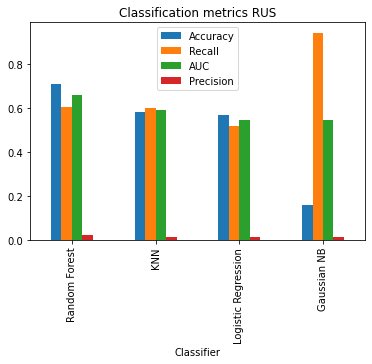

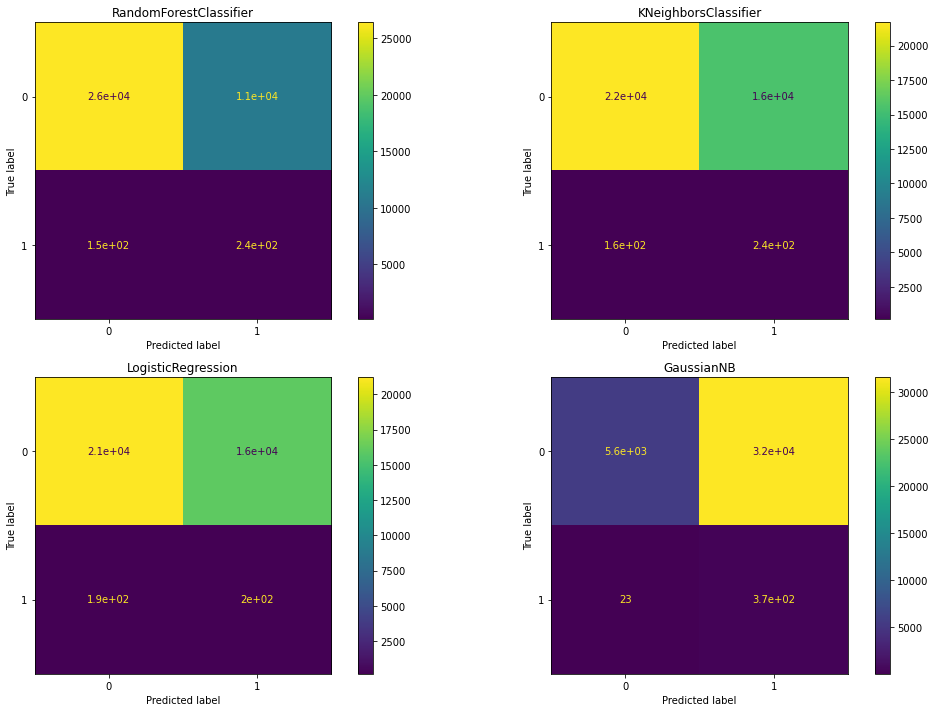

In [ ]:
#Results for the RUS
for i in range(0,len(rec_array_rus)):
  print(type(classifiers[i]).__name__)
  print()
  print('Accuracy: '+str(acc_array_rus[i]))
  print()
  print('Recall: '+ str(rec_array_rus[i]))
  print()
  print('AUC: '+ str(auc_array_rus[i]))
  print()
  print('Precision: '+ str(pre_array_rus[i]))
  print()
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


#Bar plot
plotdata = pd.DataFrame({
    "Accuracy": acc_array_rus,
    "Recall": rec_array_rus,
    "AUC": auc_array_rus,
    "Precision": pre_array_rus,    
    }, 
    index=class_names
)
plotdata.plot(kind="bar")
plt.title("Classification metrics RUS")
plt.xlabel("Classifier")
plt.show()

#Confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
i = 0
for x, ax in zip(classifiers, axes.flatten()):
  plot_confusion_matrix(x, X_test, y_test,ax=ax)
  ax.title.set_text(type(x).__name__)
plt.tight_layout()  
plt.show()




Random Over Sampler

In [ ]:
#Use of Random Over Sampling to balance classifiers for the training set
ros = RandomOverSampler(sampling_strategy=0.9)
X_ros, y_ros = ros.fit_sample(X_train, y_train)

print("Number of items in first cluster after balancing: " + str(len(y_ros)-np.count_nonzero(y_ros)))
print("Number of items in second cluster after balancing: " + str(np.count_nonzero(y_ros)))

acc_array_ros = []
rec_array_ros = []
auc_array_ros = []
pre_array_ros = []

#Training and obtaining results
for x in classifiers:
  fitmod = x.fit(X_ros,y_ros)
  y_pred = x.predict(X_test)
  conf_mat = confusion_matrix(y_test, y_pred)
  auc_array_ros.append(roc_auc_score(y_test, y_pred, average=None))
  rec_array_ros.append(recall_score(y_test, y_pred, average=None)[1])
  pre_array_ros.append(precision_score(y_test, y_pred, average=None)[1])
  acc_array_ros.append(accuracy_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Number of items in first cluster after balancing: 111776
Number of items in second cluster after balancing: 100598


RandomForestClassifier

Accuracy: 0.8828859952165825

Recall: 0.40153452685422

AUC: 0.644737294845784

Precision: 0.03625866050808314

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
KNeighborsClassifier

Accuracy: 0.9671538665958013

Recall: 0.25831202046035806

AUC: 0.6164542728043619

Precision: 0.0964660936007641

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LogisticRegression

Accuracy: 0.6968110550093011

Recall: 0.329923273657289

AUC: 0.5152932783872256

Precision: 0.011440227030862008

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
GaussianNB

Accuracy: 0.09675790592612278

Recall: 0.9104859335038363

AUC: 0.49934995136482396

Precision: 0.010375983678227922

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


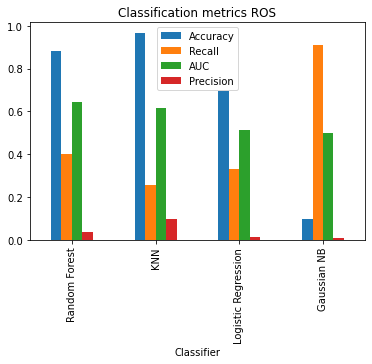

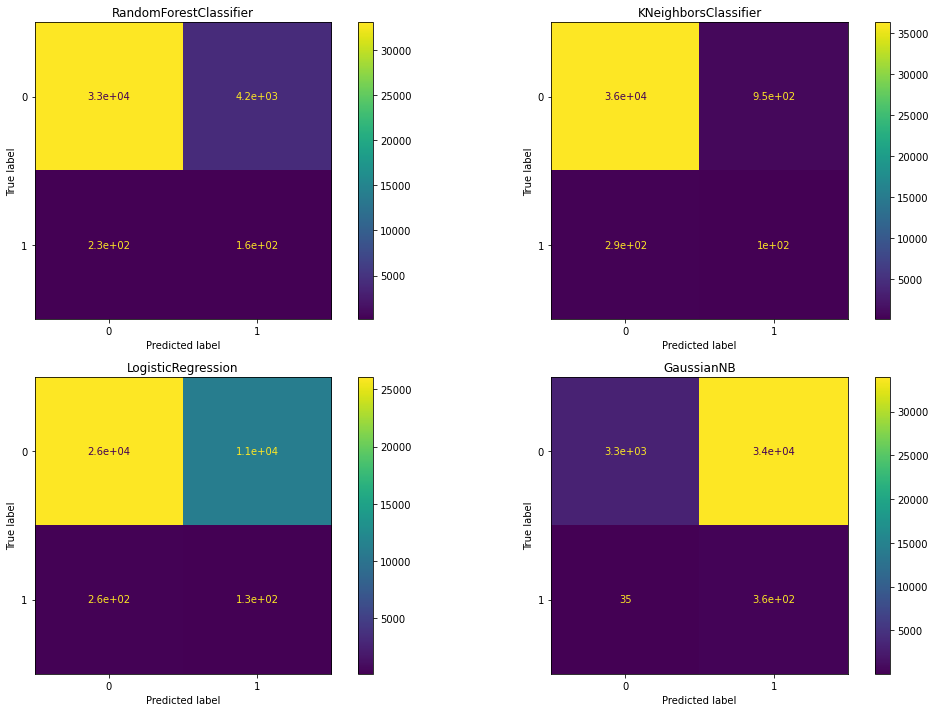

In [ ]:
#Results for the RUS
for i in range(0,len(rec_array_ros)):
  print(type(classifiers[i]).__name__)
  print()
  print('Accuracy: '+str(acc_array_ros[i]))
  print()
  print('Recall: '+ str(rec_array_ros[i]))
  print()
  print('AUC: '+ str(auc_array_ros[i]))
  print()
  print('Precision: '+ str(pre_array_ros[i]))
  print()
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


#Bar plot
plotdata = pd.DataFrame({
    "Accuracy": acc_array_ros,
    "Recall": rec_array_ros,
    "AUC": auc_array_ros,
    "Precision": pre_array_ros,    
    }, 
    index=class_names
)
plotdata.plot(kind="bar")
plt.title("Classification metrics ROS")
plt.xlabel("Classifier")
plt.show()

#Confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
i = 0
for x, ax in zip(classifiers, axes.flatten()):
  plot_confusion_matrix(x, X_test, y_test,ax=ax)
  ax.title.set_text(type(x).__name__)
plt.tight_layout()  
plt.show()


Stratified 3-fold

In [ ]:
from sklearn.model_selection import StratifiedKFold


acc_array_skf = []
rec_array_skf= []
auc_array_skf = []
pre_array_skf = []


for x in classifiers:
  acc_list = []
  recall_list = []
  precision_list = []
  auc_list = []

  skf = StratifiedKFold(n_splits=3)
  skf.get_n_splits(data_bow_c_param,data_bow_c_target)

  for train_index,test_index in skf.split(data_bow_c_param,data_bow_c_target):
    
    X1_train,X1_test = data_bow_c_param.iloc[train_index],data_bow_c_param.iloc[test_index]
    Y1_train,Y1_test = data_bow_c_target.iloc[train_index],data_bow_c_target.iloc[test_index]

    x.fit(X1_train,Y1_train)
    y_pred = x.predict(X1_test) 
    acc_score = accuracy_score(y_pred,Y1_test)
    recall_sc = recall_score(y_pred,Y1_test)
    try: 
      auc_sc = roc_auc_score(y_pred,Y1_test)
      auc_list.append(auc_sc)
    except ValueError:
      pass
    prec_score = precision_score(y_pred,Y1_test)


    acc_list.append(acc_score)
    recall_list.append(recall_sc)
    precision_list.append(prec_score)
    

  #fitmod = x.fit(X_ros,y_ros)
  acc_array_skf.append(np.array(acc_list).mean())
  rec_array_skf.append(np.array(recall_list).mean())
  auc_array_skf.append(np.array(auc_list).mean())
  pre_array_skf.append(np.array(precision_list).mean())



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

RandomForestClassifier

Average Accuracy: 0.8784163112978055

Average Recall: 0.005116959064327485

Average AUC: 0.5040829159148861

Average Precision: 0.17662682602921645

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
KNeighborsClassifier

Average Accuracy: 0.9896160006537887

Average Recall: 0.3446307805289753

Average AUC: 0.6677188171583252

Average Precision: 0.08247250518882554

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
LogisticRegression

Average Accuracy: 0.9900013287703344

Average Recall: 0.0

Average AUC: nan

Average Precision: 0.0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
GaussianNB

Average Accuracy: 0.9841416366556578

Average Recall: 0.021574516542985617

Average AUC: 0.5057911137919106

Average Precision: 0.006644082353221843

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


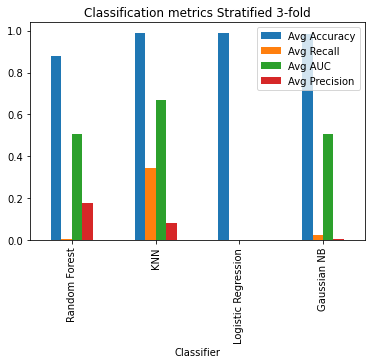

In [ ]:
#Results for the RUS
for i in range(0,len(rec_array_ros)):
  print(type(classifiers[i]).__name__)
  print()
  print('Average Accuracy: '+str(acc_array_skf[i]))
  print()
  print('Average Recall: '+ str(rec_array_skf[i]))
  print()
  print('Average AUC: '+ str(auc_array_skf[i]))
  print()
  print('Average Precision: '+ str(pre_array_skf[i]))
  print()
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


#Bar plot
plotdata = pd.DataFrame({
    "Avg Accuracy": acc_array_skf,
    "Avg Recall": rec_array_skf,
    "Avg AUC": auc_array_skf,
    "Avg Precision": pre_array_skf,    
    }, 
    index=class_names
)
plotdata.plot(kind="bar")
plt.title("Classification metrics Stratified 3-fold")
plt.xlabel("Classifier")
plt.show()



## FastText

In [ ]:
pip install fasttext==0.9.2

     |████████████████████████████████| 71kB 7.7MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3093023 sha256=44847d3c154bf733cfd691c879ccdb33b30b5ac5f0f1d19667f68aae239d2372
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
from gensim.utils import simple_preprocess
import fasttext
from fasttext import train_supervised 

#We will only use the description and the labels when applying fast text. 
data_ft = data_numeric.copy()
data_ft = data_ft[['user_description','is_conspiracy']]
data_ft['is_conspiracy'] = data_ft['is_conspiracy'].apply(str)

#Separate into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_ft['user_description'], data_ft['is_conspiracy'])

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# We use a simple preprocessor (NLP) for the user descriptions.
train.iloc[:, 0] = train.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))
test.iloc[:, 0] = test.iloc[:, 0].apply(lambda x: ' '.join(simple_preprocess(x)))

# We must prefix each row of the category column with '__label__'
train.iloc[:, 1] = train.iloc[:, 1].apply(lambda x: '__label__' + x)
test.iloc[:, 1] = test.iloc[:, 1].apply(lambda x: '__label__' + x)


# We send the train and text datasets to separated .txt files to use the library properly.
train.to_csv('train.txt', index = False, sep = ' ', header = None)  
test.to_csv('test.txt', index = False, sep = ' ', header = None)  



# We train the fastText classifier
model = fasttext.train_supervised('train.txt', wordNgrams = 2)

# We evaluate the performance on the test file, obtaining both accuracy and recall. 
model.test('test.txt')                      


(37630, 0.9909646558596864, 0.9909646558596864)

# Conclusion

TThe methods carried out in this research showed that it is possible to identify at least the majority of users that disseminated conspiracy theories and misinformation on Twitter. This is a stepping stone on the development of tools that could be used to preemptively combat potentially dangerous people on a social media platform, instead of combating posts once they have spread. While this is positive, there is still the problem that the results obtained by the currently applied classifiers and techniques were not the best, with a large number of false positives. The number of false positives could be used, however, as a basis to limit the search or surveillance of certain users. In the case of this research, this could be done by using a Random forest classifier trained using a Random under sampler.   

Alternative methods for handling class imbalance could be applied, such as different methods for managing the rate between positive and negative instances, or obtaining instances verified by experts to belong to users that spread misinformation and incorporating them in the database, though this would be labor intensive. Another approach to improving the results could be hanging the model for natural language processing. Additionally, we could perform parameter tuning or feature selection with a new text representation model in order to obtain better results. Using more tools available to researchers, it is certainly possible to improve on the performance and obtain a method that can provide, with an acceptable degree of confidence, predictions on individuals that have a negative and potentially harmful opinion on the COVID-19 vaccines. 